In [ ]:
pip install flask jupyterlab tensorflow twilio python-dotenv pandas seaborn matplotlib wordcloud scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 4.5 MB/s 
     |████████████████████████████████| 1.4 MB 69.2 MB/s 
     |████████████████████████████████| 423 kB 66.4 MB/s 
     |████████████████████████████████| 346 kB 72.0 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 9.8 MB 930 kB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 273 kB 66.3 MB/s 
     |████████████████████████████████| 80 kB 11.0 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 54 kB 1.8 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 54 kB 3.4 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle
import tensorflow as tf
import wordcloud


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/DATASET/spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data = df.copy() 
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

data = data.rename(columns={"v1":"label", "v2":"text"})
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

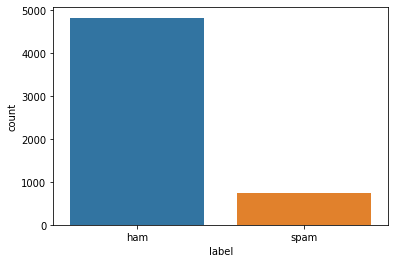

In [ ]:
sns.countplot(data['label'])
plt.show()


In [ ]:
data['label'] = data['label'].map( {'spam': 1, 'ham': 0} )

In [ ]:
data_ham  = data[data['label'] == 0].copy()
data_spam = data[data['label'] == 1].copy()

In [ ]:
def show_wordcloud(df, title):
    text = ' '.join(df['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

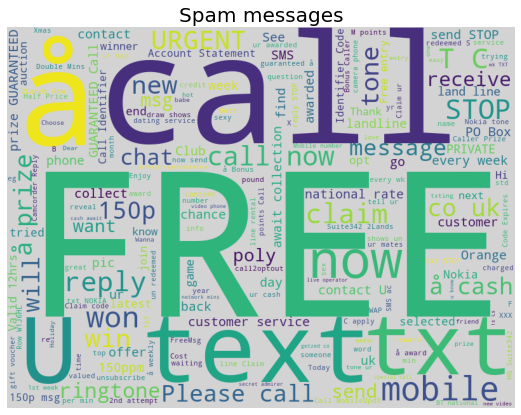

In [ ]:
show_wordcloud(data_spam, "Spam messages")

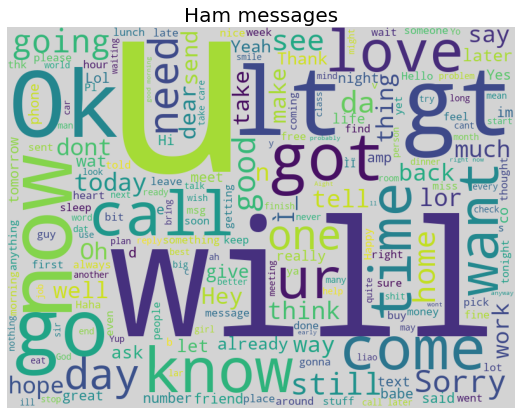

In [ ]:
show_wordcloud(data_ham, "Ham messages")


In [ ]:
# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split

In [ ]:
X = data['text'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

In [ ]:
# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[38, 30, 8, 5, 273, 1989, 81, 116, 26, 11, 1656, 322, 10, 53, 18, 299, 30, 349, 1990], [799, 15, 2555, 1442, 1127, 192, 2556, 171, 12, 98, 1991, 44, 195, 1657, 2557, 1992, 2558, 21, 9, 4, 203, 1025, 225]]


In [ ]:
# pad documents to a max length of 8words
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_train)

[[ 322   10   53 ...   30  349 1990]
 [1992 2558   21 ...  203 1025  225]
 [  83 1443    4 ...    2 3794 3795]
 ...
 [1477   30 2063 ...  239   30 2064]
 [ 763 1679 1161 ...    0    0    0]
 [   8  155   20 ...    8  290  175]]


In [ ]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 24)             190920    
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 500)               96500     
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train,
         y=y_train,
         epochs=50,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Epoch 1/50
140/140 [==============================] - 2s 9ms/step - loss: 0.1945 - accuracy: 0.9237 - val_loss: 0.0858 - val_accuracy: 0.9740
Epoch 2/50
140/140 [==============================] - 1s 7ms/step - loss: 0.0447 - accuracy: 0.9856 - val_loss: 0.0845 - val_accuracy: 0.9749
Epoch 3/50
140/140 [==============================] - 1s 7ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.1015 - val_accuracy: 0.9848
Epoch 4/50
140/140 [==============================] - 1s 7ms/step - loss: 1.5107e-04 - accuracy: 1.0000 - val_loss: 0.1789 - val_accuracy: 0.9830
Epoch 5/50
140/140 [==============================] - 1s 7ms/step - loss: 1.0149e-06 - accuracy: 1.0000 - val_loss: 0.2258 - val_accuracy: 0.9839
Epoch 6/50
140/140 [==============================] - 1s 7ms/step - loss: 1.6975e-08 - accuracy: 1.0000 - val_loss: 0.2610 - val_accuracy: 0.9839
Epoch 7/50
140/140 [==============================] - 1s 7ms/step - loss: 2.3611e-09 - accuracy: 1.0000 - val_loss: 0.2661 - val_accurac

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')


In [ ]:
preds = (model.predict(padded_test) > 0.5).astype("int32")


35/35 [==============================] - 0s 2ms/step


In [ ]:
c_report(y_test, preds)


Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.90      0.94       150

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy : 0.9847533632286996


0.9847533632286996

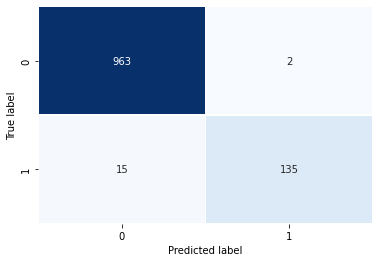

In [ ]:
plot_confusion_matrix(y_test, preds)


In [ ]:
model.save("spam_model")

In [ ]:
with open('spam_model/tokenizer.pkl', 'wb') as output:
   pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
s_model = tf.keras.models.load_model("spam_model")
with open('spam_model/tokenizer.pkl', 'rb') as input:
    tokenizer = pickle.load(input)

In [ ]:
sms = ["We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB "]
sms_proc = tokenizer.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
print(pred)

1/1 [==============================] - 0s 26ms/step
1
